# Autocodificadores

In [1]:
from __future__ import division, print_function, unicode_literals
import sys

In [3]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_figs(lst, figsize = 12):
    f, axes = plt.subplots(1, len(lst), figsize = (figsize, figsize*len(lst)))
    for i, a in enumerate(axes):
        a.matshow(lst[i], cmap = 'gray', interpolation='nearest')
        a.set(aspect='equal')
        a.axis('off')

Redes auto-codificadoras são aquelas que procuram reproduzir sua entrada na saída. Em geral, elas são formadas por duas redes simétricas, o codificador e o decodificador. A ideia do treino é reduzir o erro de reconstrução. Ou seja, a saída do decodificador deve ser o mais parecido possível com a entrada do codificador.

<img src="images/stacked-autoencoder.png" alt="Stacked AEnc" style="width: 300px;"/>

Note que o critério de otimização por minimizar o erro de reconstrução dispensa a necessidade de supervisão (uma vez que o erro é estimado diretamente da comparação da entrada com a saída). Logo, estes métodos são _não supervisionados_. Estas redes são capazes de aprender códigos baseados em atributos que representam bem a coleção completa dos dados. Ao aprenderem boas representações baseadas no que foi visto na coleção, são adequadas para encontrar anomalias (qualquer entrada que ela não consegue reproduzir bem, depois de treinada, é possívelmente anômala).

Estas redes são historicamente importantes em _deep learning_ ao tornaram possível o treino das primeiras redes profundas na segunda metade dos anos 2000. As redes treinadas de forma não supervisionada eram usadas então como ponto inicial de redes profundas, na técnica conhecida como _pré-treino_.

### Aucodificadores empilhados

A rede descrita na introdução é chamada autocodificador empilhado, pelo fato de aprender representações sob pilhas de camadas. A seguir, vamos implementar um autocodificador empilhado em tensorflow, para codificar a MNIST.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")

/home/marco/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [51]:
x_train = mnist.train.images
x_test = mnist.test.images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(55000, 784)
(10000, 784)


A rede que vamos implementar tem a seguinte arquitetura:

<img src="images/stacked-autoencoder.png" alt="Stacked AEnc" style="width: 300px;"/>

In [46]:
n_inputs = 28 * 28
n_h1 = 300
n_h2 = 150  # codings
n_h3 = n_h1
n_outputs = n_inputs

Inicialmente, criamos o autocodificador completo:

In [47]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2

input_img = Input(shape=(n_inputs,))
h1 = Dense(n_h1, activation='elu')(input_img)
h2 = Dense(n_h2, activation='elu')(h1)

h3 = Dense(n_h3, activation='elu')(h2)
decoded = Dense(n_outputs, activation='sigmoid')(h3)

autoencoder = Model(input_img, decoded)

O codificador corresponde ao autocodificador até a camada h2:

In [48]:
encoder = Model(input_img, h2)

O decodificador corresponde às últimas duas camadas do autocodificador:

In [49]:
encoded_input = Input(shape=(n_h2,))
h3 = autoencoder.layers[-2](encoded_input)
decoded = autoencoder.layers[-1](h3)
decoder = Model(encoded_input, decoded)

vamos treiná-lo com adadelta e entropia cruzada binária: 

In [50]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [52]:
autoencoder.fit(x_train, x_train,
                epochs = 50,
                batch_size = 150,
                shuffle = True,
                validation_data=(x_test, x_test))

Train on 55000 samples, validate on 10000 samples
Epoch 1/50
55000/55000 [==============================] - 2s - loss: 0.2680 - val_loss: 0.2052
Epoch 2/50
55000/55000 [==============================] - 1s - loss: 0.1819 - val_loss: 0.1627
Epoch 3/50
55000/55000 [==============================] - 1s - loss: 0.1538 - val_loss: 0.1431
Epoch 4/50
55000/55000 [==============================] - 1s - loss: 0.1380 - val_loss: 0.1302
Epoch 5/50
55000/55000 [==============================] - 1s - loss: 0.1274 - val_loss: 0.1221
Epoch 6/50
55000/55000 [==============================] - 1s - loss: 0.1200 - val_loss: 0.1150
Epoch 7/50
55000/55000 [==============================] - 1s - loss: 0.1143 - val_loss: 0.1104
Epoch 8/50
55000/55000 [==============================] - 1s - loss: 0.1097 - val_loss: 0.1058
Epoch 9/50
55000/55000 [==============================] - 1s - loss: 0.1061 - val_loss: 0.1025
Epoch 10/50
55000/55000 [==============================] - 1s - loss: 0.1033 - val_loss: 0.1005

Abaixo, vamos codificar e, em seguida, decodificar os dados de teste: 

In [53]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Agora podemos ver alguns dos exemplos de teste, originais e decodificados:

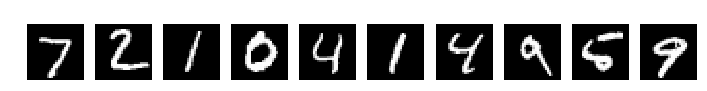

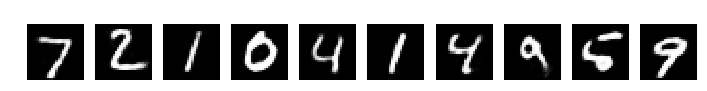

In [58]:
plot_figs([x_test[i].reshape(28, 28) for i in range(10)])
plot_figs([decoded_imgs[i].reshape(28, 28) for i in range(10)])

In [64]:
import random

def show_reconstructed_digits(X_test):
    n_test_digits = len(X_test)
    encoded_imgs = encoder.predict(X_test)
    X_recons = decoder.predict(encoded_imgs)

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for i in range(n_test_digits):
        plt.subplot(n_test_digits, 2, i * 2 + 1)
        plot_image(X_test[i])
        plt.subplot(n_test_digits, 2, i * 2 + 2)
        plot_image(X_recons[i])

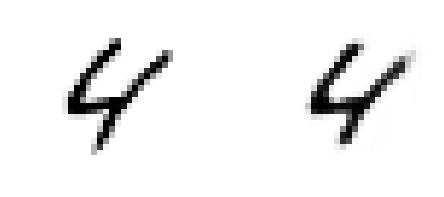

In [67]:
idx = random.randint(0, mnist.test.num_examples)
show_reconstructed_digits(mnist.test.images[idx:idx+1])

Em tensorflow puro:
    
```python
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_h1 = 300
n_h2 = 150  # codings
n_h3 = n_h1
n_outputs = n_inputs

learning_rate = 0.001
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# He initialization
he_init = tf.contrib.layers.variance_scaling_initializer() 
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

h1 = my_dense_layer(X, n_h1)
h2 = my_dense_layer(h1, n_h2)
h3 = my_dense_layer(h2, n_h3)
outputs = my_dense_layer(h3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses) # loss + L2

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(e), "MSE tr:", loss_train)           
        saver.save(s, "/tmp/my_model_all_layers.ckpt")  
```

#### Verificando casos anômalos

Uma aplicação interessante é a checagem de outliers.

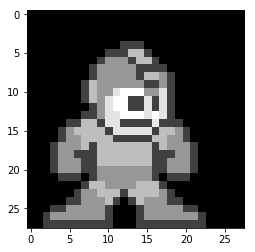

In [68]:
from PIL import Image
im = Image.open('images/warrior.png') 
image = np.asarray(im) 
image_grayscale = image.mean(axis=2).astype(np.float32)
image_grayscale /= 255. # normalize between 0 and 1
plt.imshow(image_grayscale, cmap = 'gray', interpolation = 'nearest')

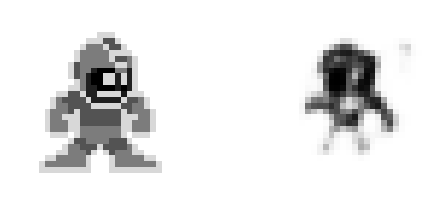

In [69]:
warrior = image_grayscale.reshape(1, 28*28)
show_reconstructed_digits(warrior)

In [89]:
def show_recloss(recloss, figs):
    fig = plt.figure()
    axplot = plt.barh(range(len(figs)), rec_loss, align='center')
    for k in range(len(figs)):
        aximg = fig.add_axes([0.01, 0.185 + 0.111*k, 0.10, 0.10])
        aximg.imshow(figs[k], cmap = 'gray', interpolation='nearest')
        aximg.set_xticks([])
        aximg.set_yticks([])

In [90]:
def reconstruction_loss(v1):
    enc_v1 = encoder.predict(v1)
    rec_v1 = decoder.predict(enc_v1)
    return np.sum(np.square(v1-rec_v1))

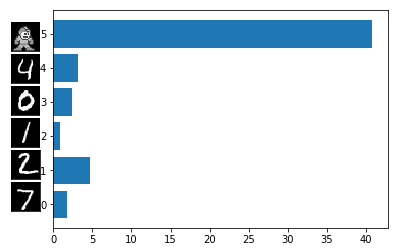

In [91]:
numfigs = 5
X_test = mnist.test.images
rec_loss = [reconstruction_loss(X_test[i].reshape(1,784))
            for i in range(numfigs)] 
rec_loss += [reconstruction_loss(warrior)]

figs = [mnist.test.images[i].reshape(28,28) for i in range(numfigs)] + [image_grayscale]
show_recloss(rec_loss, figs)

Como esperado, o erro de reconstrução de uma imagem sem similar na base (neste caso, uma anomalia) é mais alto. De fato, a primeira aplicação de auto-encoders foi a detecção de comportamento anômalo no funcionamento de helicópteros, sonares e identificação de anomalias em DNA (Japkowicz et al, 1999, _Concept-Learning in the absence of couter-examples: an autoassociation-based approach to classification_ http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.45.2551&rep=rep1&type=pdf. Neste artigo, autocodificadores são introduzidos como redes auto-associativas).

#### Observando espaço latente (o espaço de emdeddings)

In [13]:
# Ploting coded test images using TSNE
from time import time
from matplotlib import offsetbox
from sklearn import manifold

# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)
        
# t-SNE embedding of the digits dataset
def plot_tsne(XX, yy):
    print("Computing t-SNE embedding")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    t0 = time()
    X_tsne = tsne.fit_transform(XX)
    plot_embedding(X_tsne, yy,
                   "t-SNE %d embedding of the %d-D digits (time %.2fs)" %
                   (XX.shape[0], XX.shape[1], time() - t0))

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Computing t-SNE embedding


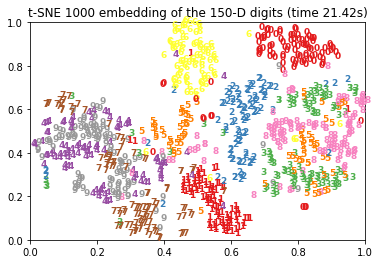

In [93]:
# coding 
cases_to_plot = 1000
idxs = np.random.permutation(mnist.test.num_examples)[:cases_to_plot]
X_test = mnist.test.images[idxs]
enc_X = encoder.predict(X_test)

plot_tsne(enc_X, mnist.test.labels[idxs])

Como vemos, digitos similares tendem a ter códigos similares e, portanto, ocupam regiões próximas no espaço. 

### Aucodificadores convolutivos

Desde que estamos usando autocodificadores para representar imagens, faz sentido criar codificadores e decodificadores usando CNNs. Para tanto, vamos precisar inverter operações de pooling. No codificador o pooling vai diminuir a imagem. No decodificador, ele deve aumentar a imagem!

In [94]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Antes de iniciar o treino, vamos preparar nossa coleção para o formato esperado pela CNN.

In [97]:
x_train = mnist.train.images
x_test = mnist.test.images
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

Neste exemplo, vamos monitorar o treino com o tensorboard. Para tanto, você deve iniciar o tensorboard no diretório da disciplina (`tensorboard --logdir=logs/autoencoder`) e usar o callback Tensorboard no Keras. Finalmente, acompanhe o treino em `http://localhost:6006`.

In [98]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='logs/autoencoder')])

Train on 55000 samples, validate on 10000 samples
Epoch 1/50
55000/55000 [==============================] - 5s - loss: 0.2444 - val_loss: 0.1695
Epoch 2/50
55000/55000 [==============================] - 4s - loss: 0.1657 - val_loss: 0.1552
Epoch 3/50
55000/55000 [==============================] - 4s - loss: 0.1498 - val_loss: 0.1402
Epoch 4/50
55000/55000 [==============================] - 4s - loss: 0.1391 - val_loss: 0.1365
Epoch 5/50
55000/55000 [==============================] - 4s - loss: 0.1315 - val_loss: 0.1276
Epoch 6/50
55000/55000 [==============================] - 4s - loss: 0.1264 - val_loss: 0.1264
Epoch 7/50
55000/55000 [==============================] - 4s - loss: 0.1233 - val_loss: 0.1214
Epoch 8/50
55000/55000 [==============================] - 4s - loss: 0.1207 - val_loss: 0.1195
Epoch 9/50
55000/55000 [==============================] - 4s - loss: 0.1190 - val_loss: 0.1168
Epoch 10/50
55000/55000 [==============================] - 4s - loss: 0.1170 - val_loss: 0.1146

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

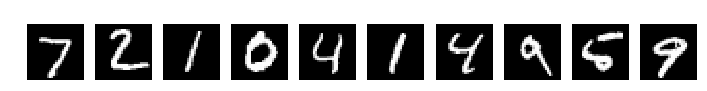

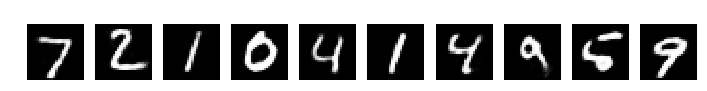

In [99]:
plot_figs([x_test[i].reshape(28, 28) for i in range(10)])
plot_figs([decoded_imgs[i].reshape(28, 28) for i in range(10)])

#### Removendo ruído com aucodificador convolutivo

Uma aplicação simples autocodificadores convolutivos é a remoção de ruído de imagens. A ideia é simplesmente mapear imagens com ruídos para as versões sem ruído e então treinar o autocodificador. Assim, dada uma imagem ruidosa, ele deve reconstruí-la com menos ruído.

Para isso, vamos começar por criar imagens ruidosas correspondentes à nossa coleção:

In [102]:
def noiser(img, noise_factor = 0.5):
    img_noisy = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    return np.clip(img_noisy, 0., 1.)

In [103]:
x_train_noisy = noiser(x_train)
x_test_noisy = noiser(x_test)

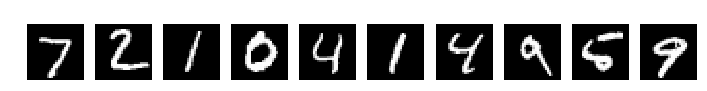

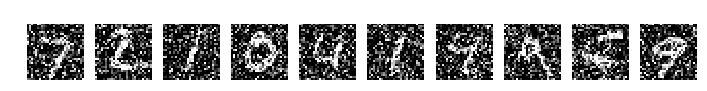

In [113]:
plot_figs([x_test[i].reshape(28, 28) for i in range(10)])
plot_figs([x_test_noisy[i].reshape(28, 28) for i in range(10)])

In [114]:
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [115]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 55000 samples, validate on 10000 samples
Epoch 1/100
55000/55000 [==============================] - 5s - loss: 0.2065 - val_loss: 0.1315
Epoch 2/100
55000/55000 [==============================] - 5s - loss: 0.1252 - val_loss: 0.1193
Epoch 3/100
55000/55000 [==============================] - 5s - loss: 0.1161 - val_loss: 0.1107
Epoch 4/100
55000/55000 [==============================] - 5s - loss: 0.1114 - val_loss: 0.1106
Epoch 5/100
55000/55000 [==============================] - 5s - loss: 0.1090 - val_loss: 0.1066
Epoch 6/100
55000/55000 [==============================] - 5s - loss: 0.1071 - val_loss: 0.1050
Epoch 7/100
55000/55000 [==============================] - 5s - loss: 0.1054 - val_loss: 0.1051
Epoch 8/100
55000/55000 [==============================] - 5s - loss: 0.1046 - val_loss: 0.1024
Epoch 9/100
55000/55000 [==============================] - 5s - loss: 0.1036 - val_loss: 0.1016
Epoch 10/100
55000/55000 [==============================] - 5s - loss: 0.1028 - val_lo

55000/55000 [==============================] - 5s - loss: 0.0948 - val_loss: 0.0943
Epoch 86/100
55000/55000 [==============================] - 5s - loss: 0.0947 - val_loss: 0.0943
Epoch 87/100
55000/55000 [==============================] - 5s - loss: 0.0947 - val_loss: 0.0943
Epoch 88/100
55000/55000 [==============================] - 5s - loss: 0.0947 - val_loss: 0.0942
Epoch 89/100
55000/55000 [==============================] - 5s - loss: 0.0947 - val_loss: 0.0943
Epoch 90/100
55000/55000 [==============================] - 5s - loss: 0.0947 - val_loss: 0.0942
Epoch 91/100
55000/55000 [==============================] - 5s - loss: 0.0946 - val_loss: 0.0947
Epoch 92/100
55000/55000 [==============================] - 5s - loss: 0.0946 - val_loss: 0.0945
Epoch 93/100
55000/55000 [==============================] - 5s - loss: 0.0946 - val_loss: 0.0944
Epoch 94/100
55000/55000 [==============================] - 5s - loss: 0.0946 - val_loss: 0.0942
Epoch 95/100
55000/55000 [=================

In [117]:
denoised_imgs = autoencoder.predict(x_test_noisy)

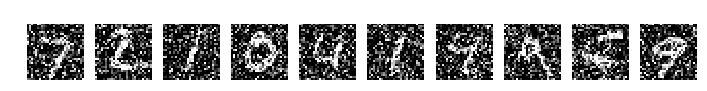

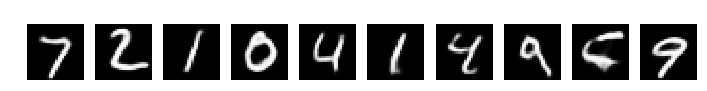

In [118]:
plot_figs([x_test_noisy[i].reshape(28, 28) for i in range(10)])
plot_figs([denoised_imgs[i].reshape(28, 28) for i in range(10)])

### Aucodificadores Variacionais

Agora vamos estudar uma nova classe de auto-codificadores, os Variacionais (VAE). Ao do contrário dos que vimos até agora, os VAE são **probabilísticos** (ou seja, seus códigos são determinados por aleatoriedade mesmo depois de treinados) e **geradores** (ou seja, podem criar _novas_ instâncias _similares_ às vistas durante o treino).

Para compreendermos esse autocodificador vamos supor que existe um espaço latente $z$, de dimensão menor que o espaço de entradas $x$, capaz de representar o espaço $x$ com o mínimo de informação redundante. Seja $p(z)$ a distribuição anterior (_prior_) do espaço latente $z$, ou seja, nosso conhecimento prévio sobre $z$ (que em nosso caso é assumir $z$ como uma variável com distribuição Gaussiana). A figura abaixo ilustra a ideia deste autocodificador. 

<img src="images/vaegaussian.png" alt="Variational Autoencoder" style="width: 400px;"/>

Nele, o codificador (uma rede neural com pesos e bias $\phi$) mapeia entradas $x$ para a distribuição posterior $q_\phi(z|x)$ sobre o espaço latente $z$ (note que o número de dimensões de $z$ é muito menor que a de $x$ e $q_\phi(z|x)$ é uma aproximação Gaussiana de $p(z|x)$). Ou seja, as saídas do decodificador são os parâmetros da distribuição $q_\phi(z|x)$ e, portanto, $z$ é um espaço estocástico. Como esta distribuição é gaussiana, seus parâmetros são as médias e desvios dos eixos do espaço $z$. 

O decodificador é uma rede neural com pesos e bias $\theta$. Dados os parâmetros da distribuição $q_\phi(z|x)$, ele pode amostrar uma instância particular de $z$, para então obter uma reconstrução $\tilde{x}$ da entrada $x$, usando a distribuição posterior $p_\theta(x|z)$.

Naturalmente, este processo perde informação, uma vez que o decodificador tem que obter uma amostra de um espaço de maior dimensionalidade usando uma distribuição baseada em um espaço latente de menor dimensionalidade. _Mas quanta informação ele perde??_ Uma forma de medir isso é calcular o log-likelihood $\log p_\phi (x|z)$. Isto nos dá uma medida de quão bem o decodificador aprendeu a reconstruir uma imagem $x$ da sua representação latente $z$. Além disso, como $q_\phi(z|x)$ é uma aproximação da distribuição real $p(z)$, o ideal é que o modelo tanto reconstrua bem a entrada quanto faça isso com uma distribuição que aproxime o melhor possível $p(z)$. Dada a entrada $x_i$, isso se traduz na seguinte função de perda:

$$\ell_i(\theta, \phi) = - E_{z\sim q_\theta(z\vert x_i)}[\log p_\phi(x_i\vert z)] + D_{KL}(q_\theta(z\vert x_i) \vert\vert p(z))$$

onde o primeiro componente corresponde à capacidade de reconstruir corretamente a entrada (ou seja, o quão bem o decodificador obtem a entrada $x_i$, dado $z$ amostrado pelo codificador para esta entrada, $x_i$). O segundo componente corresponde à diferença entre as distribuições $p(z)$ e $q_{\theta}(z|x)$ (que aproxima exatamente $p(z)$), estimada pela divergência de Kullback-Leibler.

Um problema com o VAE é que o treinamento com gradiente descendente requer que o modelo seja diferenciável com respeito aos parâmetros aprendidos, o que pressupõem que o modelo é determinístico -- uma entrada particular gera o mesmo código, dado um conjunto fixado de parâmetros. Se introduzirmos nós que fazem amostragem, o modelo se torna estocástico. Assim, a amostragem é feita por incorporar aos parâmtros do modelo um erro aleatório como entrada. Isso é chamado de _truque da reparametrização_: o modelo estima médias e desvios e, para gerar uma instância aleatória, o decodificador introduz um erro Gaussiano aleatório. Abaixo temos outra ilustração que mostra isso no VAE (do livro _Handson Machine Learning with Scikit-Learn and Tensorflow_). 

<img src="images/vae.png" alt="Variational Autoencoder" style="width: 500px;"/>

Como podemos ver, temos um autocodificador com duas camadas ocultas (vermelha e azul). A camada 2, contudo, não produz diretamente o código, mas sim a média $\mu$ e um desvio $\sigma$ do espaço latente $z$ (o espaço de codificação). Os códigos que serão usados devem ser _amostrados_ da distribuíção Gaussiana $\mathcal{N}(\mu, \sigma)$. Para isso basta introduzir um erro Guassiano no desvio.

O restante da rede é um decodificador como os que vimos antes. A ideia geral do processo é ilustrada na direita. De uma instância de treino no espaço de entrada, é derivado uma distribuição de códigos no espaço de códigos. Desta distribuição é amostrado um código (note que o ponto amostrado não corresponde ao centro da superfície Gaussiana, pois é uma amostra) que possibilita a reconstrução aproximada da saída. 

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Em termos de implementação, o VAE consiste em:

1. Um codificador que mapeia a imagem de entrada `input_img` para 2 parâmetros em um espaço latente de representação, `z_mean` e `z_log_variance`.

2. Um módulo que amostra um ponto $z$ de uma distribuição normal latente, que assumimos gerar a imagem de entrada, `viaz = z_mean + exp(z_log_variance) * epsilon`, onde `epsilon` é um tensor aleatório com valores pequenos.

3. Um decodificador que mapeia $z$, no espaço latente, de volta para a imagem de entrada.

Como `epsilon` é aleatório, este processo garante que todo ponto próximo à localização latente da imagem original (`z_mean`) pode ser decodificada para algo similar à imagem original. Ou seja, o espaço latente é _continuamente_ significativo! Quaisquer dois pontos prontos serão decodificados para imagens muito similares. Esta _continuidade_ combinada coma baixa dimensionalidade do espaço latente força que qualquer direção no espaço latente codifique eixos significativos de variação dos dados. O espaço resultante é, portanto, muito estruturado e adequado para a manipulação de _vetores conceituais_, como visto em _embeddings_.

Em um espaço latente de faces, por exemplo, pode haver um vertor `s` para a variação relacionada ao sorriso. Logo, se o ponto latente $z$ representa uma face, $z + s$ é uma representação sorridente da mesma face. Identificado tal vetor, é possível editar imagens projetando-as no espaço latente e, então, movendo sua representação na direção de forma significativa para, então, codificar a representação obtida novamente para o espaço original. Poderiamos usar esta ideia para remover óculos de pessoas, envelhecer um rosto, torná-lo mais feminino, etc. Abaixo, temos uma figura que representa uma implementação desta ideia (de Tom White, Victoria University School of Design in New Zealand, que usou VAEs treinados na coleção CelebA).

| $z-s$ | $z$ | $z+s$ |
|:---:|:-:|:---:|
|<img src="images/smilingVector1.png" alt="Vetor Sorriso" style="width: 150px;"/>  |  <img src="images/smilingVector2.png" alt="Vetor Sorriso" style="width: 150px;"/>  |  <img src="images/smilingVector3.png" alt="Vetor Sorriso" style="width: 150px;"/>|

Como visto, os parâmetros da VAE serão treinados usando duas funções de perda: a de reconstrução, que força os objetos decodificados a serem similares aos de entrada; e a de regularização, que ajuda no aprendizado de espaços latentes bem formados e reduz o _overfitting_ nos dados de treino. Em Keras, o que queremos é mais ou menos assim:

```Python
z_mean, z_log_variance = encoder(input_img)
z = z_mean + exp(z_log_variance) * epsilon
reconstructed_img = decoder(z)
model = Model(input_img, reconstructed_img)
```

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

Para este auto-codificador, vamos usar uma rede de convolução simples para mapear imagem de entrada para vetores `z_mean` e `z_log_var`.

In [41]:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Para amostrar os dados, vamos usar uma camada Lambda do Keras. Nela, os parâmetros `z_mean` e `z_log_var` são usados para gerar um ponto latente z.

In [42]:
from keras.layers import Lambda

In [43]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    # reparametrization trick!
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

Finalmente, o vator z é reformatado para ter as dimensões de uma imagem, para então ser processado pelas camadas de convolução e obter a saída final com as mesmas dimensões da iamgem original.

In [44]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
# deconvolution
x = layers.Conv2DTranspose(32, 3, padding='same', strides=(2, 2), activation='relu')(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

Agora vamos implementar nossa função de custo. Como vimos antes, ela tem dois componentes: (1) $- E_{z\sim q_\theta(z\vert x_i)}[\log p_\phi(x_i\vert z)]$ e (2) $D_{KL}(q_\theta(z\vert x_i) \vert\vert p(z))$:

$$\ell_i(\theta, \phi) = - E_{z\sim q_\theta(z\vert x_i)}[\log p_\phi(x_i\vert z)] + D_{KL}(q_\theta(z\vert x_i) \vert\vert p(z))$$

O primeiro mede o erro de reconstrução, que vamos calcular usando a entropia cruzada. O segundo (erro latente) é o que força o codificador a ter códigos que parecem amostrados de uma única distribuição Gaussiana. Para isso, usamos a divergência KL para minimizar a distância entre a distribuição que queremos (a Gaussiana) e a que é observada na realidade. A $D_{KL}$ que representa o erro latente pode ser calculada como (onde $\mathcal{B}$ representa o batch):

$$D_{KL} = - \frac{1}{2\times10^3} \frac{1}{|\mathcal{B}|} \sum_{i \in  \mathcal{B}}{1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2 }$$

Como esta função de custo não tem a forma genérica `loss(input, target)` (embora a entropia cruzada dependa da entrada e do alvo, a $D_{KL}$ depende de `z_mean` e `z_log_var`). Para implementar essa função de perda, vamos ter que usar uma camada Keras customizada que emprega o método interno `add_loss` para criar uma função de custo qualquer.

In [7]:
class CustomVariationalLayer(keras.layers.Layer):
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        self.z_mean = inputs[2]
        self.z_log_var = inputs[3]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded) 
        kl_loss = -5e-4 * K.mean(1 + self.z_log_var 
                                 - K.square(self.z_mean) 
                                 - K.exp(self.z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

y = CustomVariationalLayer()([input_img, z_decoded, z_mean, z_log_var])

Finalmente, podemos instanciar o modelo. Como a função de perda foi implementada como uma camada, não precisamos especificá-la na compilação (ou seja, `loss = None`). Da mesma forma, passamos apenas x_train no treino, uma vez que a função de perda customizada sabe que o rótulo é a própria imagem de entrada.

In [8]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
mnist.train.images.shape + (1,)

(55000, 784, 1)

In [11]:
x_train = mnist.train.images.reshape(-1, 28, 28, 1)
x_test = mnist.test.images.reshape(-1, 28, 28, 1)

In [12]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=1,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 55000 samples, validate on 10000 samples
Epoch 1/1
55000/55000 [==============================] - 601s - loss: 0.2246 - val_loss: 0.2009


Para vermos a continuidade da distribuição de diferentes classes de dígitos, vamos plotar um grid de imagens aleatórias, de forma que possamos observar todo o espectro de variação das dimensões _x_ e _y_. 

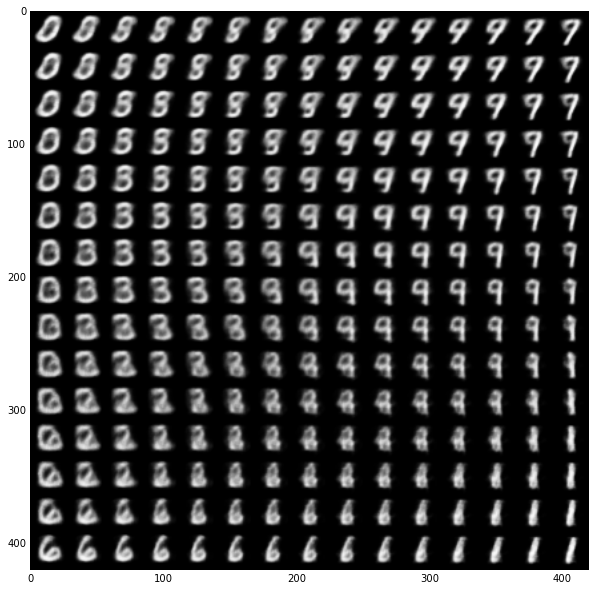

In [36]:
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

À medida que andamos pelos eixos, os digitos vão se transformando uns nos outros, de forma contínua. Ou seja, a transição é fluída, com o dígito sendo aos poucos _transformado_ no outro. Direções específicas neste espaço tem significado -- representam conhecimento sobre a forma dos dígitos: por exemplo, há uma direção específica para a forma do 6, do 1, do 7 e assim em diante.

Note que VAE não está preso a uma distribuição Gaussiana. De fato, diferentes distribuições podem ser melhores. A grande vantagem da interpretação aleatória do espaço de código (espaço latente) é que ela possibilita a geração de _novos_ casos. Isso permite uma nova classe de modelos e problemas: aqueles em que queremos _gerar_ instâncias a partir de exemplos.

#### Observando o espaço latente

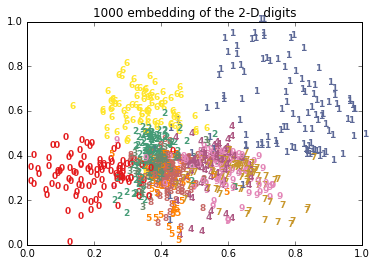

In [37]:
# coding 
cases_to_plot = 1000
idxs = np.random.permutation(mnist.test.num_examples)[:cases_to_plot]
X_test = mnist.test.images[idxs].reshape(cases_to_plot, 28, 28, 1)
enc_X = encoder.predict(X_test)
plot_embedding(enc_X, mnist.test.labels[idxs], 
               title = '%d embedding of the 2-D digits' % (cases_to_plot))

Note que além dos citados, há muitos outros tipos de auto-codificadores que merecem atenção:

* _Contractive autoencoder_ (CAE): auto-codificador é criado para reforçar a ideia de que entradas similares tenham códigos similares -- Contractive Auto-Encoders: Explicit Invariance During Feature Extraction, S. Rifai et al. (2011).
* _Stacked convolutional autoencoder_: apredem a extrair atributos visuais por reconstruir imagens processadas por camadas de convolução.
* _Generative stochastic network_ (GSN): generalização da ideia de autocodificadores robustos a ruidos extendidos para gerar dados.
* _Winner-take-all (WTA) autoencoder_: um autocodificador esparso que obtem esparsidade por permitie que apeans k% das maiores ativaçãoes sejam preservadas durante o treino (as outras são zeradas).
* _Adversarial autoencoder_: uma rede é treinada para reproduzir sua saída enquanto outra é treinada para achar entradas que a primeira nao consegue reconstruir direito. Ao fim do treino, a primeira rede se torna muito robusta.

Grande parte desta aula foi derivada do livro _Deep Learning with Python_, de Chollet. Há também muito material baseado no de de Aurélian Géron (_Handson Machine Learning with Scikit-learn and Tensorflow_), de Jaan Altosaar (https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) e de Miriam Shiffman (http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html).